# Starter cell 
## Run this cell first to enable working with this notebook

In [1]:
# Starter cell: make repo root importable, then run bootstrap
import sys
from pathlib import Path

# If running a notebook inside scripts/, cwd is .../perch-scale-bird-weights/scripts
# -> parent() is the repo root. If your notebooks are deeper, bump parents[2], etc.
ROOT = Path.cwd()
for _ in range(5):       # walk up to 5 levels until we find the repo
    if (ROOT / ".git").exists() or (ROOT / "README.md").exists():
        break
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))


# Generate Figure 2 - Control experiment - Validation of the perch-scale

## Panel A - Vertically stacked time series traces of the measured objects

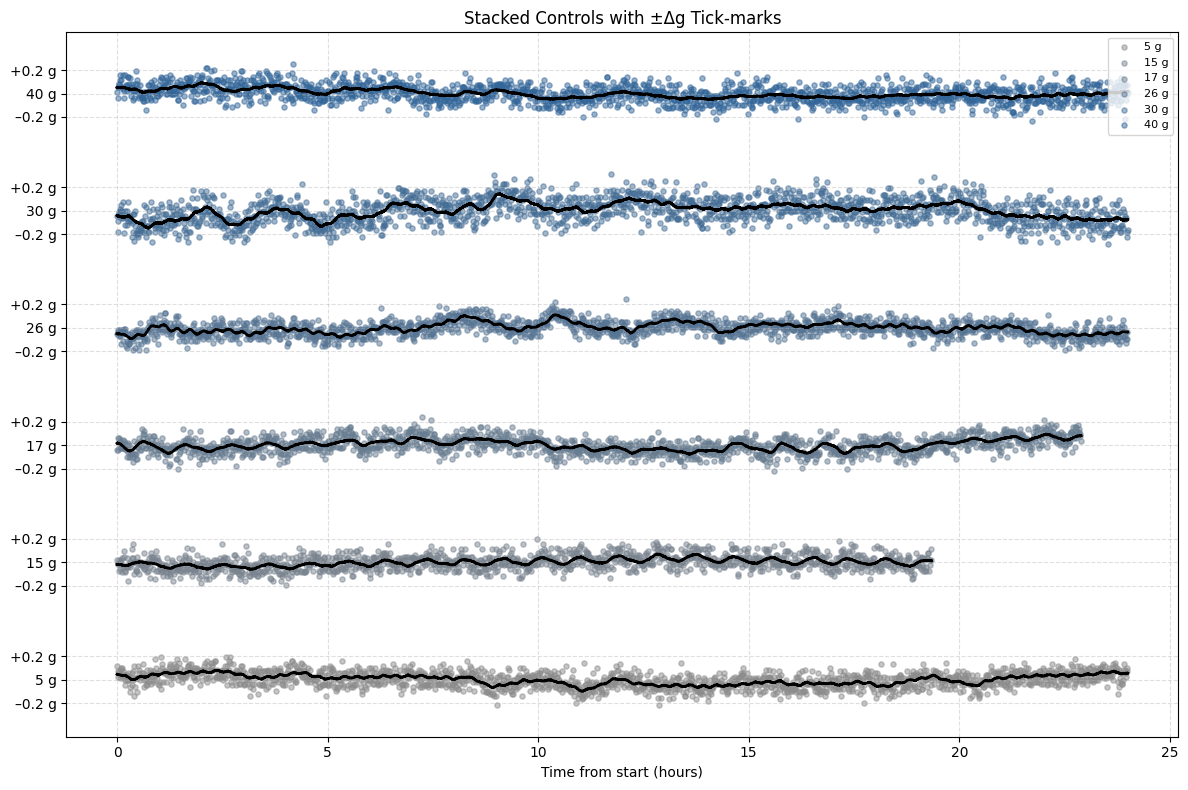

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap

# --- repo paths (assumes _paths.CONTROLS -> data/controls) ---
from scripts._paths import CONTROLS

# --- user params ------------------------------------------------
weights       = [5, 15, 17, 26, 30, 40]
hours_limit   = 24
downsample_by = 40
scale = 1.5
# ----------------------------------------------------------------

# prefer .csv.gz, fall back to .csv
def _control_file(w: int) -> Path:
    base = CONTROLS / f"control_{w}_weight_report.csv"
    gz = base.with_suffix(".csv.gz")
    return gz if gz.exists() else base

# build a 60%‐dark grey→blue map
grey_blue_60 = LinearSegmentedColormap.from_list(
    "grey_blue_60",
    ["#8C8C8C", "#336699"]
)
colors = grey_blue_60(np.linspace(0, 1, len(weights)))

fig, ax = plt.subplots(figsize=(12, 8))

# first: plot stacked scatters & black smooths (unchanged logic)
for idx, w in enumerate(weights):
    path = _control_file(w)
    df = pd.read_csv(path, parse_dates=['Time'])
    # files now already have 'time' and 'weight' columns
    # keep a local copy of column names just in case
    if 'weight' not in df.columns:
        # fallback for legacy naming
        df.rename(columns={df.columns[1]: 'weight'}, inplace=True)

    df['t'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()/3600
    df = df[df['t'] <= hours_limit]
    df_down = df.iloc[::downsample_by]

    mu      = df['weight'].mean()
    y_sc    = (df_down['weight'] - mu)*scale + (idx+1)
    ax.scatter(df_down['t'], y_sc, color=colors[idx], alpha=0.5, s=14, label=f"{w} g")

    smooth  = df['weight'].rolling(500, center=True, min_periods=1).mean()
    y_ln    = (smooth - mu)*scale + (idx+1)
    ax.plot(df['t'], y_ln, color='k', lw=2)

# now: custom y‐ticks (baseline ± delta)
yticks, ytlabels = [], []
for idx, w in enumerate(weights):
    path = _control_file(w)
    df = pd.read_csv(path, parse_dates=['Time'])
    if 'weight' not in df.columns:
        df.rename(columns={df.columns[1]:'weight'}, inplace=True)
    std_dev = df['weight'].std()

    delta = 0.2 if std_dev < 0.2 else 0.25
    base  = idx+1

    yticks   += [base - delta, base, base + delta]
    ytlabels += [f"–{delta} g", f"{w} g", f"+{delta} g"]

ax.set_yticks(yticks)
ax.set_yticklabels(ytlabels)
ax.set_xlabel('Time from start (hours)')
ax.set_title('Stacked Controls with ±Δg Tick‐marks')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()


## Panel B - Comparison between manually acquired ground truth weights and the acquired perch-scale data

Control Weight Analysis Results:

File: 5
  Mode Weight: 5.01
  Actual Weight: 5
  Median Weight: 5.01
  Std Weight: 0.045314091797535566
  Num Records: 72156

File: 15
  Mode Weight: 15.78
  Actual Weight: 15.75
  Median Weight: 15.78
  Std Weight: 0.04129731433185387
  Num Records: 58144

File: 17
  Mode Weight: 17.39
  Actual Weight: 17.3
  Median Weight: 17.38
  Std Weight: 0.04498175164617445
  Num Records: 68826

File: 26
  Mode Weight: 26.57
  Actual Weight: 26.8
  Median Weight: 26.57
  Std Weight: 0.043754262482896
  Num Records: 72153

File: 30
  Mode Weight: 29.9
  Actual Weight: 30
  Median Weight: 29.9
  Std Weight: 0.07635550117787976
  Num Records: 349245

File: 40
  Mode Weight: 40.56
  Actual Weight: 40.6
  Median Weight: 40.56
  Std Weight: 0.056889333655670504
  Num Records: 349245


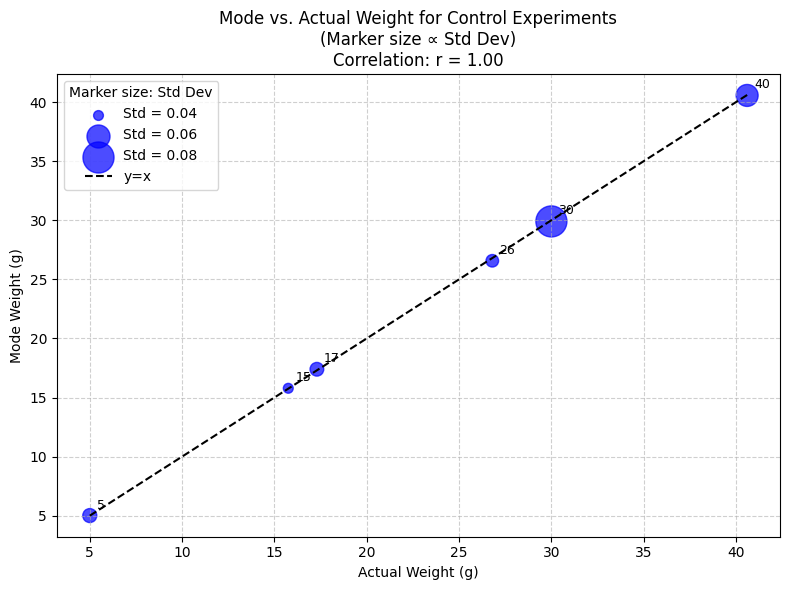

In [3]:
# read control weight analysis results:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# --- repo paths (assumes _paths.META -> data/metadata) ---
from scripts import _paths as P
control_results_path = P.META / "control_weight_analysis_results.json"

# Load the control weight analysis results
with open(control_results_path, "r") as f:
    control_res = json.load(f)

# Print the control results
print("Control Weight Analysis Results:")
for fname, metrics in control_res.items():
    print(f"\nFile: {fname}")
    print(f"  Mode Weight: {metrics.get('mode_weight', 'N/A')}")
    print(f"  Actual Weight: {metrics.get('actual_weight', 'N/A')}")
    print(f"  Median Weight: {metrics.get('median_weight', 'N/A')}")
    print(f"  Std Weight: {metrics.get('std_weight', 'N/A')}")
    print(f"  Num Records: {metrics.get('num_records', 'N/A')}")

# Plot mode vs. actual weight for each control
actual_weights = []
mode_weights = []
labels = []
std_weights = []

for fname, metrics in control_res.items():
    actual = metrics.get("actual_weight")
    mode = metrics.get("mode_weight")
    std = metrics.get("std_weight")
    if actual is not None and mode is not None and std is not None:
        actual_weights.append(actual)
        mode_weights.append(mode)
        labels.append(fname)
        std_weights.append(std)

# Normalize std_weights for marker size
if std_weights:
    min_size, max_size = 50, 500
    std_arr = np.array(std_weights)
    if std_arr.max() > std_arr.min():
        sizes = min_size + (std_arr - std_arr.min()) / (std_arr.max() - std_arr.min()) * (max_size - min_size)
    else:
        sizes = np.full_like(std_arr, (min_size + max_size) / 2)
else:
    sizes = 100

plt.figure(figsize=(8, 6))
plt.scatter(actual_weights, mode_weights, s=sizes, color="blue", alpha=0.7)

# annotate points
for i, label in enumerate(labels):
    plt.annotate(label, (actual_weights[i], mode_weights[i]), textcoords="offset points", xytext=(5, 5), ha="left", fontsize=9)

# y=x reference
if actual_weights:
    lo, hi = min(actual_weights), max(actual_weights)
    plt.plot([lo, hi], [lo, hi], "k--", label="y=x")

plt.xlabel("Actual Weight (g)")
plt.ylabel("Mode Weight (g)")

# correlation
if len(actual_weights) > 1:
    corr_coef = np.corrcoef(actual_weights, mode_weights)[0, 1]
    plt.title(f"Mode vs. Actual Weight for Control Experiments\n(Marker size ∝ Std Dev)\nCorrelation: r = {corr_coef:.2f}")
else:
    plt.title("Mode vs. Actual Weight for Control Experiments\n(Marker size ∝ Std Dev)")

# Legend for marker size (std dev)
if std_weights:
    std_legend_vals = np.linspace(np.min(std_weights), np.max(std_weights), 3)
    if np.max(std_weights) > np.min(std_weights):
        size_legend_vals = min_size + (std_legend_vals - np.min(std_weights)) / (np.max(std_weights) - np.min(std_weights)) * (max_size - min_size)
    else:
        size_legend_vals = np.full_like(std_legend_vals, (min_size + max_size) / 2)
    handles = [plt.scatter([], [], s=size, color="blue", alpha=0.7, label=f"Std = {std:.2f}")
               for std, size in zip(std_legend_vals, size_legend_vals)]
    plt.legend(handles=handles + [mlines.Line2D([], [], color="k", linestyle="--", label="y=x")],
               title="Marker size: Std Dev", loc="best")
else:
    plt.legend()

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# fig_save_name = P.FIGS / "control_comparison.svg"
# plt.savefig(fig_save_name, bbox_inches="tight", dpi=300, format="svg")

plt.show()
